torch에는 imdb 데이터를 제공하지 않음. 그래서 keras에서 데이터셋을 받아와서 훈련.

In [ ]:
import torch
from tensorflow import keras
from keras.datasets import imdb
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

# IMDB 데이터셋
(train_input, train_target), (test_input, test_target) =\
    imdb.load_data(num_words=500)

# 훈련/검증 세트 분리
train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42
)

# 패딩 처리
train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

print(train_seq.shape, train_target.shape)

(20000, 100) (20000,)


In [2]:
# 파이토치 torch.tensor 자료형으로 변환
train_seq = torch.tensor(train_seq)
val_seq = torch.tensor(val_seq)

train_target.dtype

dtype('int64')

파이토치에서의 타겟 데이터는 0과 1만 있더라도, 실수 형태여야 한다.

In [3]:
train_target = torch.tensor(train_target, dtype=torch.float32)
val_target = torch.tensor(val_target, dtype=torch.float32)

train_target.dtype

torch.float32

In [4]:
from torch.utils.data import TensorDataset, DataLoader

# TensorDataset: 가공된 입력과 타깃을 하나의 PyTorch 데이터셋으로 통합
train_dataset = TensorDataset(train_seq, train_target)
val_dataset = TensorDataset(val_seq, val_target)

# DataLoader: 32 배치 단위로, 훈련 세트는 섞어서(shuffle) 검증 데이터는 순서대로 나눠준다.
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [5]:
# 층 구성 - nn.Module 클래스 상속을 통한 RNN 기반 IMDB 이진 분류 모델
import torch.nn as nn

class IMDBRnn(nn.Module):
    def __init__(self):
        super().__init__()

        # 단어 인덱스를 16차원 임베딩 벡터로 변환 (단어 수 500개 제한)
        self.embedding = nn.Embedding(500, 16)

        # RNN 층: 입력 크기 16 (임베딩 차원), 은닉 상태 크기 8
        # batch_first=True → 입력, 출력 텐서 shape를 바꿈
        # : (시퀀스 길이, 배치 크기, 임베딩 크기) → (배치 크기, 시퀀스 길이, 임베딩 크기)
        self.rnn = nn.RNN(16, 8, batch_first=True)

        # 완전 연결층: RNN의 마지막 은닉 상태(8차원)를 1차원으로 매핑
        self.dense = nn.Linear(8, 1)

        # 시그모이드 활성화 함수: 0~1 사이 확률값 출력
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x: (batch_size, seq_len)
        x = self.embedding(x)      # → (batch_size, seq_len, embedding_dim)
        _, hidden = self.rnn(x)    # hidden: (1, batch_size, hidden_size)

        
        outputs = self.dense(hidden[-1])
        return self.sigmoid(outputs)

In [6]:
from torchinfo import summary
model = IMDBRnn()

summary(model)

Layer (type:depth-idx)                   Param #
IMDBRnn                                  --
├─Embedding: 1-1                         8,000
├─RNN: 1-2                               208
├─Linear: 1-3                            9
├─Sigmoid: 1-4                           --
Total params: 8,217
Trainable params: 8,217
Non-trainable params: 0

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

IMDBRnn(
  (embedding): Embedding(500, 16)
  (rnn): RNN(16, 8, batch_first=True)
  (dense): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [8]:
# 옵티마이저, 손실함수
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

In [9]:
train_hist = []  # loss값 기록
val_hist = []  # loss값 기록
patience = 3
best_loss = 2
early_stopping_counter = 0

epochs = 100
for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    total_train = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device).float()
        optimizer.zero_grad()

        outputs = model(inputs).squeeze(1)  # outputs.squeeze(1): 2차원 배열 -> 1차원 배열
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = (outputs >= 0.5).float()
        train_correct += (preds == targets).sum().item()
        total_train += targets.size(0)

    model.eval()
    val_loss = 0
    val_correct = 0
    total_val = 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device).float()
            outputs = model(inputs).squeeze(1)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

            preds = (outputs >= 0.5).float()
            val_correct += (preds == targets).sum().item()
            total_val += targets.size(0)

    train_loss /= len(train_loader)  # 훈련 세트의 1에포크당 평균 loss
    val_loss /= len(val_loader)  # 검증 세트의 1에포크당 평균 loss
    train_acc = train_correct / total_train
    val_acc = val_correct / total_val

    train_hist.append(train_loss)
    val_hist.append(val_loss)

    print(f"Epochs {epoch+1}/{epochs}")
    print(f"accuracy: {train_acc:.4f} - loss: {train_loss:.4f} - val_accuracy: {val_acc:.4f} - val_loss: {val_loss:.4f}")

    if (val_loss < best_loss):
        best_loss = val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_rnn_model.pth')
    else:
        early_stopping_counter += 1
        if (early_stopping_counter >= patience):
            print(f"Early Stopped - {epoch+1} epochs")
            break

Epochs 1/100
accuracy: 0.5262 - loss: 0.6920 - val_accuracy: 0.5556 - val_loss: 0.6836
Epochs 2/100
accuracy: 0.5609 - loss: 0.6783 - val_accuracy: 0.5904 - val_loss: 0.6655
Epochs 3/100
accuracy: 0.6222 - loss: 0.6460 - val_accuracy: 0.6626 - val_loss: 0.6201
Epochs 4/100
accuracy: 0.6593 - loss: 0.6209 - val_accuracy: 0.5332 - val_loss: 0.7420
Epochs 5/100
accuracy: 0.6418 - loss: 0.6334 - val_accuracy: 0.6738 - val_loss: 0.6053
Epochs 6/100
accuracy: 0.6946 - loss: 0.5824 - val_accuracy: 0.6844 - val_loss: 0.6013
Epochs 7/100
accuracy: 0.7139 - loss: 0.5667 - val_accuracy: 0.7126 - val_loss: 0.5747
Epochs 8/100
accuracy: 0.7249 - loss: 0.5562 - val_accuracy: 0.7210 - val_loss: 0.5686
Epochs 9/100
accuracy: 0.7046 - loss: 0.5784 - val_accuracy: 0.7082 - val_loss: 0.5833
Epochs 10/100
accuracy: 0.7163 - loss: 0.5709 - val_accuracy: 0.7222 - val_loss: 0.5733
Epochs 11/100
accuracy: 0.7286 - loss: 0.5525 - val_accuracy: 0.6990 - val_loss: 0.5989
Early Stopped - 11 epochs


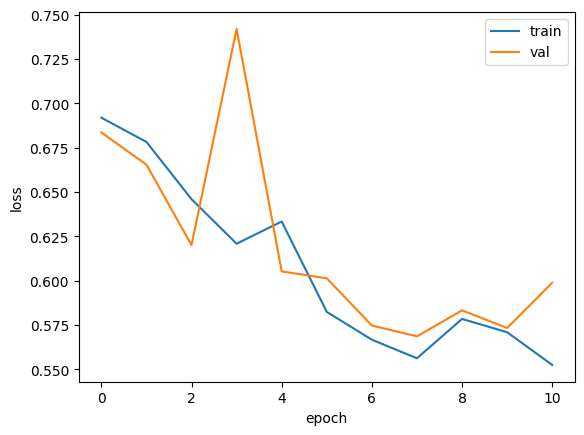

In [10]:
import matplotlib.pyplot as plt

plt.plot(train_hist, label='train')
plt.plot(val_hist, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [12]:
model.load_state_dict(torch.load('best_rnn_model.pth', weights_only=True))

<All keys matched successfully>

In [13]:
model.eval()
corrects = 0
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        predicts = outputs.squeeze() > 0.5
        corrects += (predicts == targets).sum().item()

accuracy = corrects / len(val_dataset)
print(f"검증 정확도: {accuracy:.4f}")

검증 정확도: 0.7210
